# Road extraction from satellite images using U-net

In [1]:
# Importing relevant libraries
import pandas as pd
from PIL import Image
import cv2, os, tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Dropout, Conv2DTranspose, Concatenate, Lambda, BatchNormalization, Activation, LeakyReLU
from keras.utils.vis_utils import plot_model

In [2]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData(frameObj, imgPath, maskPath, shape):
    imgNames = os.listdir(imgPath)
    maskNames = []
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (1000):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [3]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/train', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/train'
                         , shape = 256)

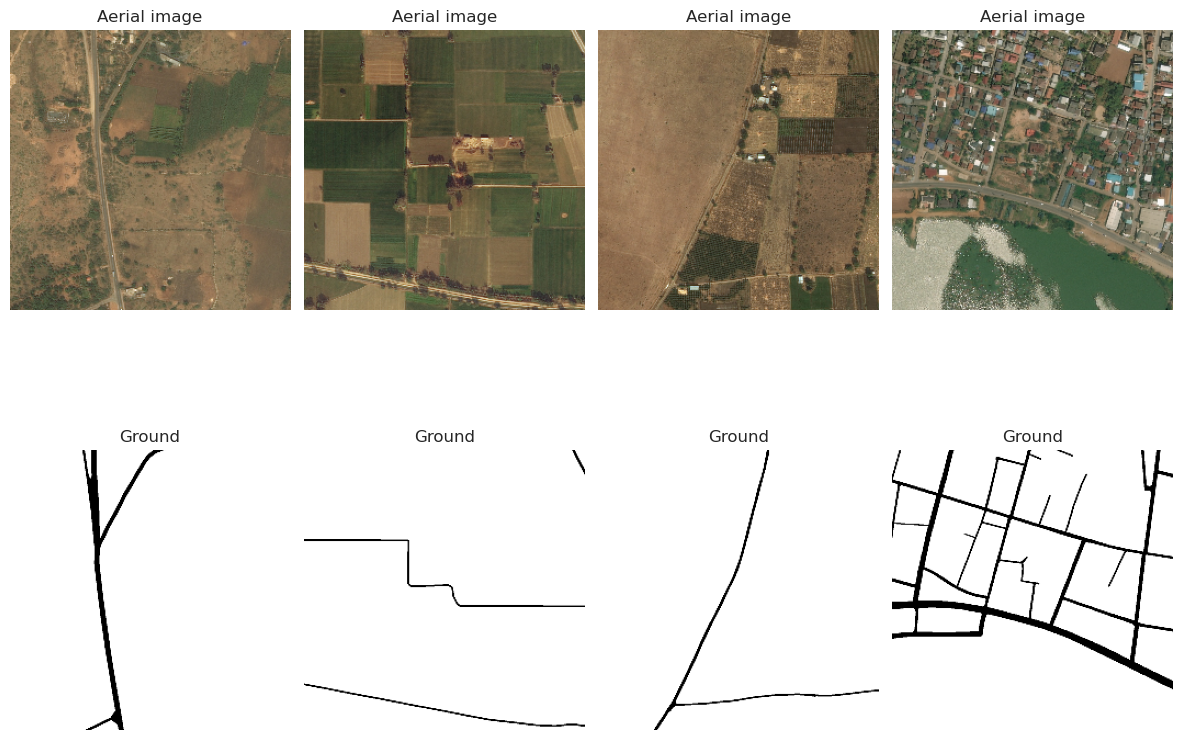

In [4]:
fig, ax = plt.subplots(figsize = (15, 10))
for i in range(1,5):
    idx = np.random.randint(1, 1000)
    mask =  np.array(framObjTrain['mask'][idx])
    image = np.array(framObjTrain['img'][idx])
    
    plt.subplot(2, 4, i)
    plt.imshow(image)
    plt.title('Aerial image')
    plt.axis("off")
    
    plt.subplot(2, 4, i + 4)
    plt.imshow(mask)
    plt.title('Ground')
    plt.axis("off")

plt.subplots_adjust(wspace=0.05)
plt.show()

In [5]:
NUMBER_OF_CHANNELS = 3

IMG_HEIGHT = 256
IMG_WIDTH = 256

KERNEL_SIZE = 3
POOL_SIZE = (2, 2)

UPSCALE_KERNEL_SIZE = 2
UPSCALE_STRIDE_SIZE = 2

FILTERS = 64

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, KERNEL_SIZE, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, KERNEL_SIZE, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def downscale_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    pool = MaxPool2D(POOL_SIZE)(x)
    return [pool, x]

def upscale_block(input_tensor, concat_tensor, num_filters):
    upscale  = Conv2DTranspose(num_filters, UPSCALE_KERNEL_SIZE, UPSCALE_STRIDE_SIZE, padding = "same")(input_tensor)
    new_tensor = Concatenate()([upscale, concat_tensor])
    x = conv_block(new_tensor, num_filters)
    return x

def U_net(input_shape, filters):
    input_tensor = Input(input_shape)
    input_tenosr = Lambda(lambda x : x/255)(input_tensor)
    
    downscale_1 = downscale_block(input_tensor, filters*1)
    downscale_2 = downscale_block(downscale_1[0], filters*2)
    downscale_3 = downscale_block(downscale_2[0], filters*4)
    downscale_4 = downscale_block(downscale_3[0], filters*8)
    downscale_5 = downscale_block(downscale_4[0], filters*16)
    
    mid_conv = conv_block(downscale_5[0], filters*32)
    
    upscale_1 = upscale_block(mid_conv, downscale_5[1], filters*16)
    upscale_2 = upscale_block(upscale_1, downscale_4[1], filters*8)
    upscale_3 = upscale_block(upscale_2, downscale_3[1], filters*4)
    upscale_4 = upscale_block(upscale_3, downscale_2[1], filters*2)
    upscale_5 = upscale_block(upscale_4, downscale_1[1], filters*1)
    
    output_tensor = Conv2D(1, 1, padding="same", activation="relu")(upscale_5)
    
    model = Model(inputs = input_tensor, outputs = output_tensor)
    return model

In [6]:
Unet =U_net((IMG_HEIGHT, IMG_HEIGHT, NUMBER_OF_CHANNELS), FILTERS)
Unet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='binary_crossentropy')

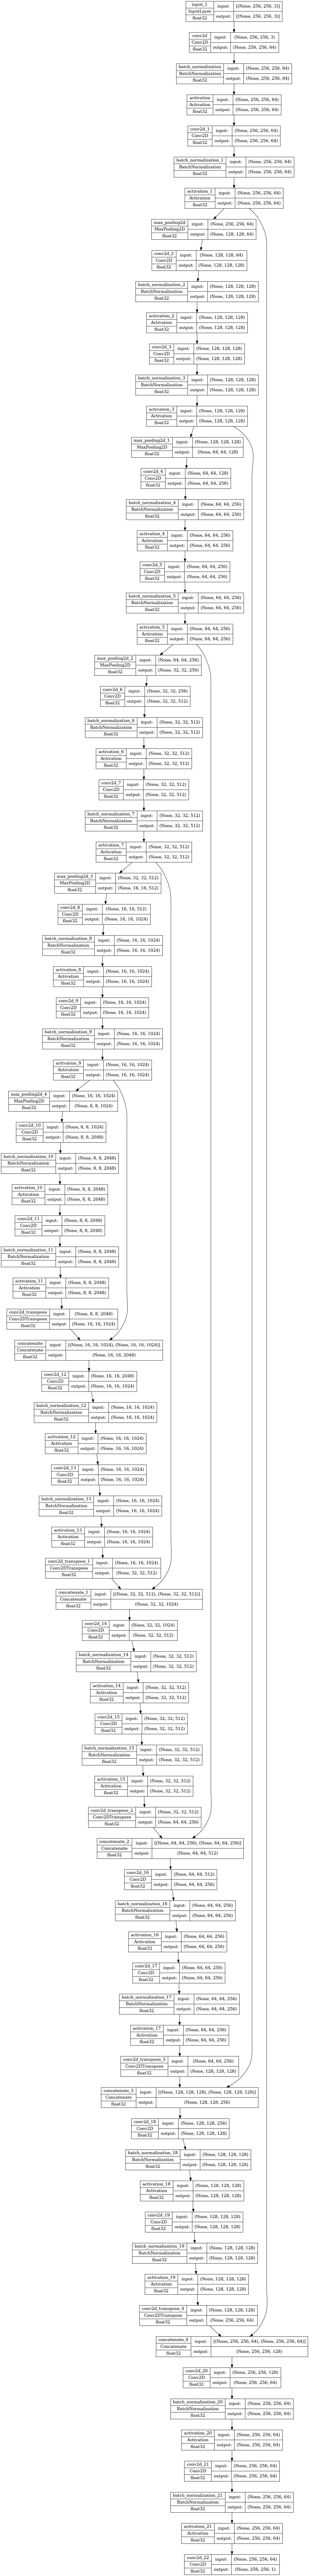

In [7]:
plot_model(Unet, to_file="/kaggle/working/U-net.png", show_shapes=True, show_dtype=True, show_layer_names=True)

In [8]:
training_history_1 = Unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 40, verbose = 1)

Epoch 1/40
32/32 [==============================] - 59s 970ms/step - loss: 0.6416
Epoch 2/40
32/32 [==============================] - 29s 892ms/step - loss: 0.2014
Epoch 3/40
32/32 [==============================] - 29s 892ms/step - loss: 0.1753
Epoch 4/40
32/32 [==============================] - 29s 893ms/step - loss: 0.1678
Epoch 5/40
32/32 [==============================] - 29s 894ms/step - loss: 0.1706
Epoch 6/40
32/32 [==============================] - 29s 894ms/step - loss: 0.1634
Epoch 7/40
32/32 [==============================] - 29s 894ms/step - loss: 0.1591
Epoch 8/40
32/32 [==============================] - 29s 893ms/step - loss: 0.1553
Epoch 9/40
32/32 [==============================] - 29s 894ms/step - loss: 0.1549
Epoch 10/40
32/32 [==============================] - 29s 893ms/step - loss: 0.1527
Epoch 11/40
32/32 [==============================] - 29s 894ms/step - loss: 0.1537
Epoch 12/40
32/32 [==============================] - 29s 894ms/step - loss: 0.1530
Epoch 13/40
3

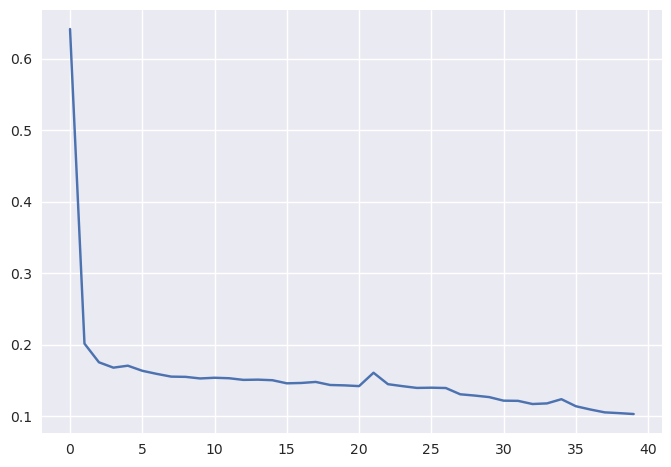

In [9]:
plt.plot(training_history_1.history["loss"])
plt.show()

1/1 [==============================] - 0s 23ms/step


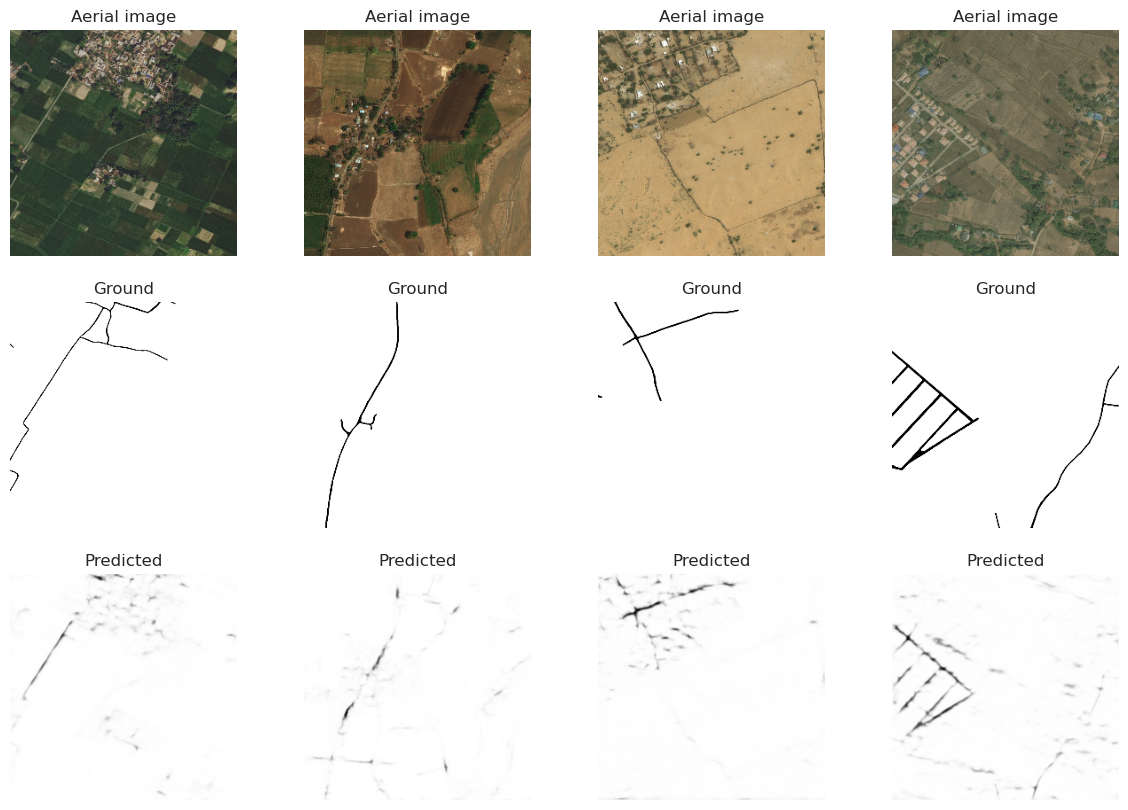

In [10]:
fig, ax = plt.subplots(figsize = (15, 10))
for i in range(1,5):
    idx = np.random.randint(1, 1000)
    mask =  np.array(framObjTrain['mask'][idx])
    image = np.array(framObjTrain['img'][idx])
    predicted = Unet.predict(tf.expand_dims(image, axis=0))[0]
    
    plt.subplot(3, 4, i)
    plt.imshow(image)
    plt.title('Aerial image')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 4)
    plt.imshow(mask)
    plt.title('Ground')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 8)
    plt.imshow(predicted)
    plt.title('Predicted')
    plt.axis("off")

plt.subplots_adjust(wspace=0.05)
plt.show()

In [34]:
Unet.save('/kaggle/working/1st_try.h5')

1/1 [==============================] - 0s 22ms/step


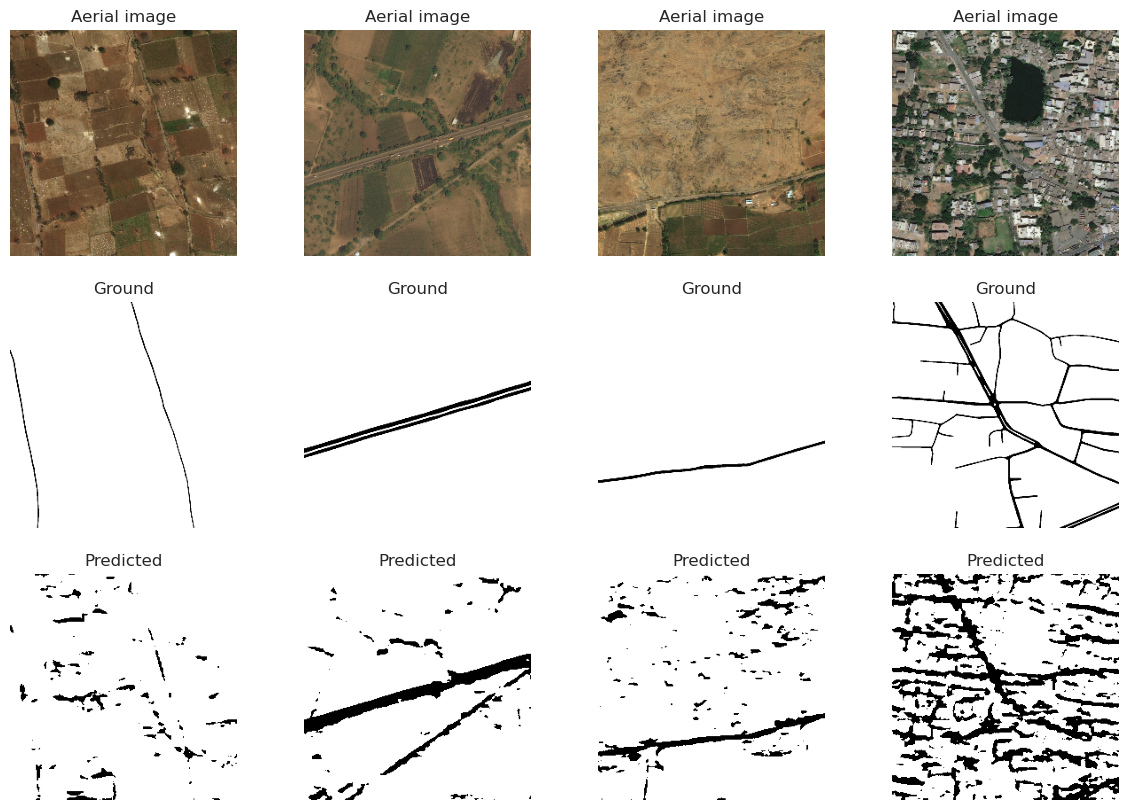

In [33]:
thres = 0.0459
fig, ax = plt.subplots(figsize = (15, 10))
for i in range(1,5):
    idx = np.random.randint(1, 1000)
    mask =  np.array(framObjTrain['mask'][idx])
    image = np.array(framObjTrain['img'][idx])
    predicted = np.where(Unet.predict(tf.expand_dims(image, axis=0))[0] >= thres, 1, 0)
    
    plt.subplot(3, 4, i)
    plt.imshow(image)
    plt.title('Aerial image')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 4)
    plt.imshow(mask)
    plt.title('Ground')
    plt.axis("off")
    
    plt.subplot(3, 4, i + 8)
    plt.imshow(predicted)
    plt.title('Predicted')
    plt.axis("off")

plt.subplots_adjust(wspace=0.05)
plt.show()